In [6]:
!pip install pandas
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
from datetime import datetime

In [8]:
# Random seed for reproducibility
RND = 42
np.random.seed(RND)

In [11]:
# Map any value to 1-100 scale
def normalize_1_100(val, vmin, vmax):
    return np.clip(1.0 + 99.0 * (val - vmin) / (vmax - vmin + 1e-9), 1.0, 100.0)

In [13]:
def compute_student_ratings(student):
    """
    student: dict with features like attendance, homework, classwork, class focus, exam, skills
    Returns dict with subcategory scores, overall rating
    """
    # ---- Attendance ----
    att = student.get("attendance", 80)  # percentage
    r_att = normalize_1_100(att, 0, 100)
    
    # ---- Homework/Classwork ----
    hw = student.get("homework", 7)      # 1-10 scale
    cw = student.get("classwork", 7)     # 1-10 scale
    r_hw = normalize_1_100(hw, 1, 10)
    r_cw = normalize_1_100(cw, 1, 10)
    
    # ---- Class Focus ----
    focus = student.get("class_focus", 70)  # percentage
    r_focus = normalize_1_100(focus, 0, 100)
    
    # ---- Exam ----
    exam = student.get("exam", 65)  # percentage
    r_exam = normalize_1_100(exam, 0, 100)
    
    # ---- Skills ----
    skills = student.get("skills", {"problem_solving":7, "communication":7, "discipline":7})
    r_skills = {k: normalize_1_100(v, 1, 10) for k,v in skills.items()}
    
    # ---- Overall rating ----
    weights = {
        "attendance": 0.2,
        "homework": 0.15,
        "classwork": 0.1,
        "class_focus": 0.15,
        "exam": 0.25,
        "skills": 0.15
    }
    overall = (
        r_att*weights["attendance"] +
        r_hw*weights["homework"] +
        r_cw*weights["classwork"] +
        r_focus*weights["class_focus"] +
        r_exam*weights["exam"] +
        np.mean(list(r_skills.values()))*weights["skills"]
    )
    
    return {
        "overall_rating": round(overall,2),
        "subcategories": {
            "Attendance": round(r_att,2),
            "Homework": round(r_hw,2),
            "Classwork": round(r_cw,2),
            "Class Focus": round(r_focus,2),
            "Exam": round(r_exam,2),
            "Skills": {k: round(v,2) for k,v in r_skills.items()}
        }
    }

In [15]:
def recommend_improvement(ratings_dict):
    subcats = ratings_dict["subcategories"]
    
    # Find weakest main category
    main_scores = {
        "Attendance": subcats["Attendance"],
        "Homework/Classwork": (subcats["Homework"] + subcats["Classwork"])/2,
        "Class Focus": subcats["Class Focus"],
        "Exam": subcats["Exam"],
        "Skills": np.mean(list(subcats["Skills"].values()))
    }
    weakest = min(main_scores, key=main_scores.get)
    
    recs = {
        "Attendance": "Improve class presence; track absences and ensure punctuality.",
        "Homework/Classwork": "Submit homework & classwork on time; improve quality and consistency.",
        "Class Focus": "Increase concentration in class; use short quizzes and active participation.",
        "Exam": "Practice exam strategy, time management, and answer organization.",
        "Skills": "Enhance key skills through practice, presentations, and problem-solving drills."
    }
    
    return weakest, recs[weakest]

In [38]:
from matplotlib.patches import FancyBboxPatch
import numpy as np

def draw_student_card(student_id, ratings_dict):
    sub = ratings_dict["subcategories"]
    fig, ax = plt.subplots(figsize=(4,6))
    ax.axis('off')
    
    # Card background
    card = FancyBboxPatch((0,0), 100, 150, boxstyle="round,pad=0.02", facecolor="#fafafa", edgecolor="gray")
    ax.add_patch(card)
    
    # Header
    ax.text(50, 140, "STUDENT RATING CARD", ha='center', fontsize=10, fontweight='bold')
    ax.text(50, 125, student_id, ha='center', fontsize=12, fontweight='bold')
    ax.text(50, 110, str(ratings_dict["overall_rating"]), ha='center', fontsize=30, fontweight='bold', color='darkgoldenrod')
    
    # Subcategories
    y = 90
    for k,v in sub.items():
        if k != "Skills":
            ax.text(10, y, k, fontsize=9)
            ax.text(90, y, f"{v:.1f}", fontsize=9, ha='right')
            y -= 9
    # Skills
    skill_text = ", ".join([f"{k}:{v}" for k,v in sub["Skills"].items()])
    ax.text(10, 30, "Skills: "+skill_text+"/n", fontsize=7, wrap=True)
    
    plt.show()

In [39]:
# Example student input
student_data = {
    "attendance": 75,      # percentage
    "homework": 6,         # 1-10
    "classwork": 7,        # 1-10
    "class_focus": 65,     # percentage
    "exam": 60,            # percentage
    "skills": {
        "problem_solving": 6,
        "communication": 7,
        "discipline": 6
    }
}

# Compute ratings
ratings = compute_student_ratings(student_data)

# Recommendations
weakest, rec = recommend_improvement(ratings)

# Show results
print("Overall Rating:", ratings["overall_rating"])
print("Weakest Category:", weakest)
print("Recommendation:", rec)
print("Subcategory Scores:", ratings["subcategories"])

# Draw card
draw_student_card("STUDENT_001", ratings)

Overall Rating: 64.0
Weakest Category: Skills
Recommendation: Enhance key skills through practice, presentations, and problem-solving drills.
Subcategory Scores: {'Attendance': np.float64(75.25), 'Homework': np.float64(56.0), 'Classwork': np.float64(67.0), 'Class Focus': np.float64(65.35), 'Exam': np.float64(60.4), 'Skills': {'problem_solving': np.float64(56.0), 'communication': np.float64(67.0), 'discipline': np.float64(56.0)}}


In [40]:
#for photo addition and card image
from PIL import Image

In [58]:
from PIL import Image

def draw_full_student_card(student_id, ratings_dict, photo_path=None):
    """
    Draw a full FIFA-style student card:
    - All subcategories
    - Weakest category
    - Recommendation
    - Student photo
    """
    sub = ratings_dict["subcategories"]
    
    # Determine weakest category & recommendation
    weakest, recommendation = recommend_improvement(ratings_dict)
    
    fig, ax = plt.subplots(figsize=(6,8))
    ax.axis('off')
    
    # Card background
    ax.add_patch(plt.Rectangle((0,0), 100, 150, facecolor="#f5f5f5", edgecolor="gray", linewidth=2))
    
    # Photo (if provided)
    if photo_path:
        try:
            img = Image.open(photo_path)
            img = img.resize((80,80))
            ax.imshow(img, extent=(10,90,135,215))
        except Exception as e:
            print("Error loading photo:", e)
    
    # Header
    ax.text(50, 140, "STUDENT CARD", ha='center', fontsize=12, fontweight='bold')
    ax.text(50, 125, student_id, ha='center', fontsize=12, fontweight='bold')
    
    # Overall Rating
    ax.text(50, 110, str(ratings_dict["overall_rating"]), ha='center', fontsize=30, fontweight='bold', color='darkgoldenrod')
    
    # Subcategories
    y = 95
    for k,v in sub.items():
        if k != "Skills":
            ax.text(10, y, f"{k}: {v:.1f}", fontsize=10)
            y -= 12
    # Skills
    skills_text = "\n ".join([f"{k}:{v:.1f}" for k,v in sub["Skills"].items()])
    ax.text(10, y, f"Skills: {skills_text}", fontsize=9, wrap=True)
    y -= 15
    
    # Weakest category and recommendation
    ax.text(10, y, f"Weakest: {weakest}", fontsize=10, fontweight='bold', color='red')
    y -= 9
    ax.text(10, y, f"Recommendation: {recommendation}", fontsize=9, wrap=True)
    
    plt.xlim(0,100)
    plt.ylim(0,150)
    plt.show()

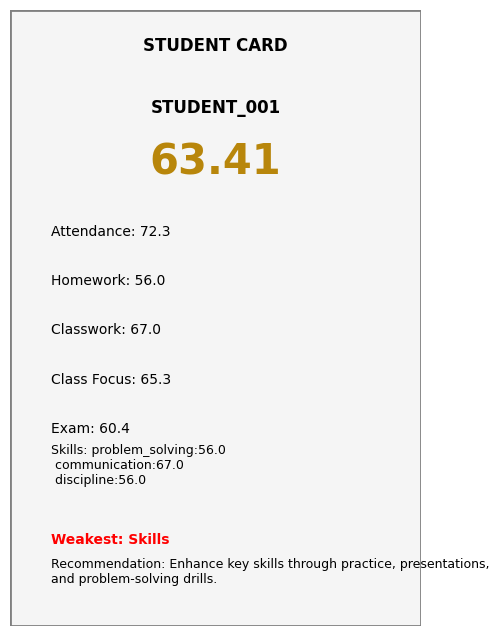

In [59]:
# Student input
student_data = {
    "attendance": 72,
    "homework": 6,
    "classwork": 7,
    "class_focus": 65,
    "exam": 60,
    "skills": {
        "problem_solving": 6,
        "communication": 7,
        "discipline": 6
    }
}

# Compute ratings
ratings = compute_student_ratings(student_data)

# Provide photo path
photo_path = "student_photos/student_001.jpg"  # replace with actual photo path

# Draw full card
draw_full_student_card("STUDENT_001", ratings, photo_path=photo_path)

In [4]:
import pickle

object_to save = 

NameError: name 'model' is not defined